## Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../modules'))
from best_models import models_to_cv
from cross_validation import cross_validation

## Setup

In [12]:
np.random.seed(42)

In [13]:
train_data = pd.read_csv('../data/train_winsor_1_norm.csv')
X_train = train_data.drop(columns='class')
y_train = train_data['class']

In [14]:
val_data = pd.read_csv('../data/validation_winsor_1_norm.csv')
X_val = val_data.drop(columns='class')
y_val = val_data['class']

In [15]:
test_data = pd.read_csv('../data/teste.csv')
X_test = test_data.drop(columns='class')
y_test = test_data['class']

In [16]:
y_train.value_counts()

class
1    8659
0    4574
Name: count, dtype: int64

In [17]:
y_test.value_counts()

class
1    1809
0    1027
Name: count, dtype: int64

In [18]:
y_val.value_counts()

class
1    1864
0     972
Name: count, dtype: int64

In [19]:
best_trials = {}
model_names = ['KNN','DTR', 'SVM', 'RF', 'XGB', 'LGBM', 'MLP', 'LVQ']

In [20]:
best_models, ensembles = models_to_cv()

In [21]:
import time
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.pipeline import Pipeline, make_pipeline
import statistics as st
from imblearn.over_sampling import ADASYN

def stress_testing(X_train, y_train, X_test, y_test, pipelines, use_adasyn=False):
    if use_adasyn == True:
            adasyn = ADASYN(sampling_strategy='auto', random_state=42)
            X_train, y_train = adasyn.fit_resample(X_train, y_train)
            
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values

    # Lists to store the metrics
    test_metrics = {
        'model_name': [],
        'ACSA': [],
        'recall': [],
        'CM': [],
        'f1_score': [],
        'training_time': [],
        'inference_time': [],
        'error_rate': [],
        'train_accuracy': [],
        'test_accuracy': [],
        'precision': [],
    }

    for model_name, pipeline in pipelines.items():
        print(f'Model {model_name}')

        start_train = time.time()
        fitted_model = pipeline.fit(X_train, y_train)
        stop_train = time.time()
        training_time = stop_train - start_train

        # Train and test predictions
        y_train_pred = fitted_model.predict(X_train)
        start_test = time.time()
        y_test_pred = fitted_model.predict(X_test)
        stop_test = time.time()
        inference_time = stop_test - start_test

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        error_rate = 1 - test_accuracy  # Error rate is 1 - accuracy
        rec = recall_score(y_test, y_test_pred)
        conf_matrix = confusion_matrix(y_test, y_test_pred)
        class_accuracies = np.diag(conf_matrix) / conf_matrix.sum(axis=1)
        acsa = class_accuracies.mean()

        # Storing metrics
        test_metrics['train_accuracy'].append(train_accuracy)
        test_metrics['test_accuracy'].append(test_accuracy)
        test_metrics['f1_score'].append(f1)
        test_metrics['precision'].append(prec)
        test_metrics['error_rate'].append(error_rate)
        test_metrics['recall'].append(rec)
        test_metrics['model_name'].append(model_name)
        test_metrics['ACSA'].append(acsa)
        test_metrics['CM'].append(conf_matrix)
        test_metrics['training_time'].append(training_time)
        test_metrics['inference_time'].append(inference_time)
                    
    metrics = pd.DataFrame(test_metrics)

    if use_adasyn == True:
        metrics.to_csv(f'../metrics/metrics_stress_test_adasyn.csv', index=False)
    else:
        metrics.to_csv(f'../metrics/metrics_stress_test.csv', index=False)

    print(f'\n Metrics: \n{metrics}')
    
    return metrics

## Imports

In [22]:
best_models, ensembles = models_to_cv()

In [23]:
best_models.update(ensembles)

In [24]:
best_models

{'KNN': KNeighborsClassifier(algorithm='brute', metric='manhattan', n_neighbors=10),
 'LVQ': LVQ(epochs=32, lrate=0.2756588, n_codebooks=15),
 'DTR': DecisionTreeClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=3),
 'SVM': SVC(C=0.25868, max_iter=1000, probability=True),
 'RF': RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=3,
                        n_estimators=366),
 'XGB': GradientBoostingClassifier(learning_rate=0.05147, max_depth=6, n_estimators=374,
                            subsample=0.571017),
 'LGBM': LGBMClassifier(learning_rate=0.0758, max_depth=13, n_estimators=180,
                num_leaves=52, subsample=0.987176),
 'MLP': MLPClassifier(alpha=0.005, hidden_layer_sizes=(100, 50)),
 'Heterogêneo': StackingClassifier(estimators=[('pipeline_1',
                                 GradientBoostingClassifier(learning_rate=0.05147,
                                                            max_depth=6,
                                  

# No adasyn

In [26]:
val_metrics_no_adasyn = stress_testing(X_train, y_train, X_val, y_val, best_models, use_adasyn=False)
val_metrics_no_adasyn 

Model KNN
Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model RF
Model XGB
Model LGBM
[LightGBM] [Info] Number of positive: 8659, number of negative: 4574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 13233, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654349 -> initscore=0.638211
[LightGBM] [Info] Start training from score 0.638211
Model MLP


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Heterogêneo
[LightGBM] [Info] Number of positive: 8659, number of negative: 4574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 13233, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654349 -> initscore=0.638211
[LightGBM] [Info] Start training from score 0.638211
[LightGBM] [Info] Number of positive: 6927, number of negative: 3659
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 10586, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654355 -> initscore=0.638237
[LightGBM] [Info] Start training from score 0.638237
[L

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision
0,KNN,0.788035,0.948498,"[[610, 362], [96, 1768]]",0.885328,0.004603,2.436047,0.161495,0.869946,0.838505,0.830047
1,LVQ,0.725351,0.927039,"[[509, 463], [136, 1728]]",0.852281,40.799520,0.145593,0.211213,0.794151,0.788787,0.788681
2,DTR,0.784753,0.926502,"[[625, 347], [137, 1727]]",0.877095,0.042681,0.000000,0.170663,0.880753,0.829337,0.832690
3,SVM,0.699999,0.969957,"[[418, 554], [56, 1808]]",0.855655,4.178471,0.239115,0.215092,0.788181,0.784908,0.765453
4,RF,0.837976,0.950644,"[[705, 267], [92, 1772]]",0.908019,15.775352,0.128101,0.126587,0.969999,0.873413,0.869053
5,XGB,0.849741,0.947425,"[[731, 241], [98, 1766]]",0.912426,23.669381,0.015717,0.119535,0.959571,0.880465,0.879920
6,LGBM,0.854617,0.946888,"[[741, 231], [99, 1765]]",0.914508,12.492587,0.024762,0.116361,0.966296,0.883639,0.884269
7,MLP,0.843881,0.950107,"[[717, 255], [93, 1771]]",0.910540,61.169533,0.015104,0.122708,0.885740,0.877292,0.874136
8,Heterogêneo,0.853834,0.946352,"[[740, 232], [100, 1764]]",0.913990,89.609107,0.015626,0.117066,0.966145,0.882934,0.883768
9,ANNs,0.844310,0.933476,"[[734, 238], [124, 1740]]",0.905778,40.465500,0.015633,0.127645,0.883473,0.872355,0.879676


In [25]:
test_metrics_no_adasyn = stress_testing(X_train, y_train, X_test, y_test, best_models, use_adasyn=False)
test_metrics_no_adasyn 

Model KNN


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:150: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 227, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, clo

Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model RF


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model XGB
Model LGBM
[LightGBM] [Info] Number of positive: 8659, number of negative: 4574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 13233, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654349 -> initscore=0.638211
[LightGBM] [Info] Start training from score 0.638211
Model MLP
Model Heterogêneo
[LightGBM] [Info] Number of positive: 8659, number of negative: 4574
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 13233, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScor

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision
0,KNN,0.500000,0.000000,"[[1027, 0], [1809, 0]]",0.000000,0.001999,0.269208,0.637870,0.869946,0.362130,0.000000
1,LVQ,0.500638,0.549475,"[[464, 563], [815, 994]]",0.590612,26.539858,0.168416,0.485896,0.784327,0.514104,0.638407
2,DTR,0.503317,0.006633,"[[1027, 0], [1797, 12]]",0.013180,0.059348,0.000000,0.633639,0.881811,0.366361,1.000000
3,SVM,0.500000,0.000000,"[[1027, 0], [1809, 0]]",0.000000,3.657463,0.446939,0.637870,0.788181,0.362130,0.000000
4,RF,0.500000,0.000000,"[[1027, 0], [1809, 0]]",0.000000,15.380776,0.061326,0.637870,0.969319,0.362130,0.000000
5,XGB,0.503040,0.006081,"[[1027, 0], [1798, 11]]",0.012088,17.758106,0.015227,0.633992,0.959571,0.366008,1.000000
6,LGBM,0.500553,0.001106,"[[1027, 0], [1807, 2]]",0.002209,0.536381,0.000000,0.637165,0.966296,0.362835,1.000000
7,MLP,0.719034,0.717523,"[[740, 287], [511, 1298]]",0.764879,35.658290,0.000000,0.281382,0.883171,0.718618,0.818927
8,Heterogêneo,0.500829,0.001658,"[[1027, 0], [1806, 3]]",0.003311,90.253219,0.015626,0.636812,0.965919,0.363188,1.000000
9,ANNs,0.651222,0.355998,"[[972, 55], [1165, 644]]",0.513557,59.995830,0.031342,0.430183,0.883624,0.569817,0.921316


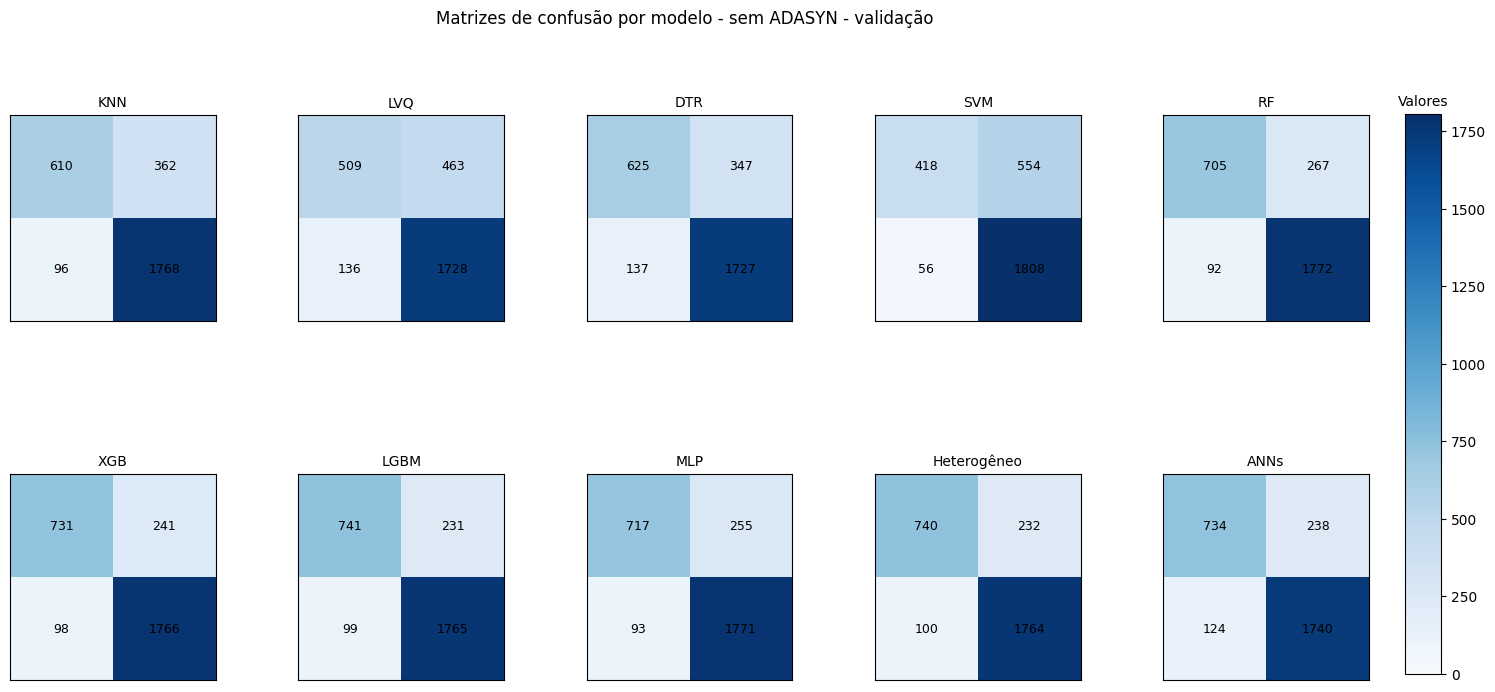

In [27]:
confusion_matrices = val_metrics_no_adasyn['CM']
models = val_metrics_no_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - sem ADASYN - validação')

plt.show()

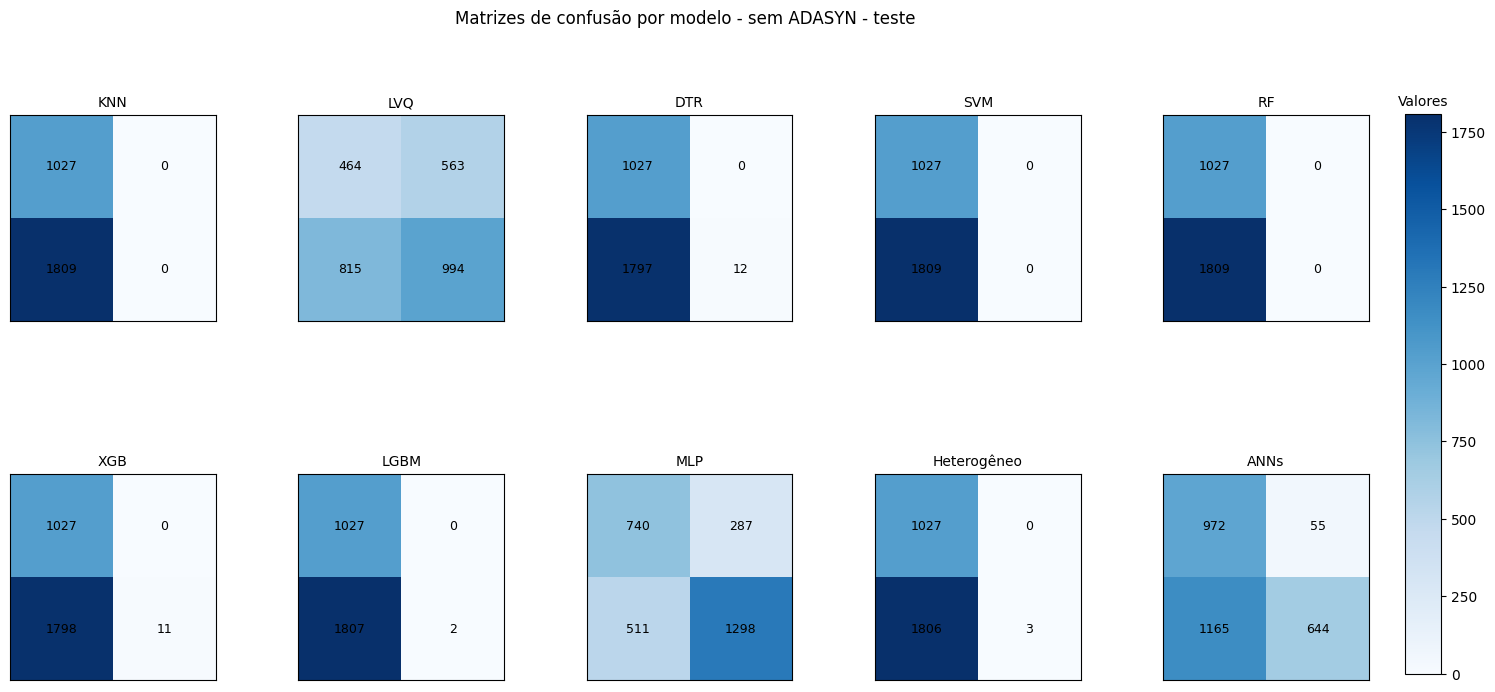

In [28]:
confusion_matrices = test_metrics_no_adasyn['CM']
models = test_metrics_no_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - sem ADASYN - teste')

plt.show()

# With adasyn

In [ ]:
val_metrics_with_adasyn = stress_testing(X_train, y_train, X_val, y_val, best_models, use_adasyn=True)
val_metrics_with_adasyn

Model KNN
Model LVQ


In [ ]:
test_metrics_with_adasyn = stress_testing(X_train, y_train, X_test, y_test, best_models, use_adasyn=True)
test_metrics_with_adasyn

Model KNN
Model LVQ
Model DTR
Model SVM


c:\Users\giull\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Model RF
Model XGB
Model LGBM
[LightGBM] [Info] Number of positive: 4576, number of negative: 4790
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 89
[LightGBM] [Info] Number of data points in the train set: 9366, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.488576 -> initscore=-0.045705
[LightGBM] [Info] Start training from score -0.045705
Model MLP
Model Heterogêneo
Model ANNs

 Metrics: 
    model_name      ACSA    recall                         CM  f1_score  \
0          KNN  0.957782  0.959519   [[1131, 52], [64, 1517]]  0.963175   
1          LVQ  0.845428  0.715370  [[1154, 29], [450, 1131]]  0.825246   
2          DTR  0.938795  0.931689  [[1119, 64], [108, 1473]]  0.944836   
3          SVM  0.951131  0.953827   [[1122, 61], [73, 1508]]  0.9

,model_name,ACSA,recall,CM,f1_score,training_time,inference_time,error_rate,train_accuracy,test_accuracy,precision
0,KNN,0.957782,0.959519,"[[1131, 52], [64, 1517]]",0.963175,0.227756,0.868208,0.041968,0.987615,0.958032,0.966858
1,LVQ,0.845428,0.715370,"[[1154, 29], [450, 1131]]",0.825246,52.920085,1.710167,0.173300,0.851591,0.826700,0.975000
2,DTR,0.938795,0.931689,"[[1119, 64], [108, 1473]]",0.944836,1.834606,0.057988,0.062229,0.928251,0.937771,0.958360
3,SVM,0.951131,0.953827,"[[1122, 61], [73, 1508]]",0.957460,17.759706,10.909943,0.048480,0.963165,0.951520,0.961122
4,RF,0.961801,0.955724,"[[1145, 38], [70, 1511]]",0.965495,10.829948,0.597014,0.039074,0.978326,0.960926,0.975468
5,XGB,0.963796,0.966477,"[[1137, 46], [53, 1528]]",0.968621,8.429821,0.029608,0.035818,0.986440,0.964182,0.970775
6,LGBM,0.965590,0.968374,"[[1139, 44], [50, 1531]]",0.970215,2.372168,0.013422,0.034009,0.986974,0.965991,0.972063
7,MLP,0.959047,0.962049,"[[1131, 52], [60, 1521]]",0.964490,22.284497,0.007831,0.040521,0.987401,0.959479,0.966942
8,Heterogêneo,0.965697,0.967742,"[[1140, 43], [51, 1530]]",0.970197,8.116941,1.083039,0.034009,0.987615,0.965991,0.972664
9,ANNs,0.963477,0.968374,"[[1134, 49], [50, 1531]]",0.968681,108.983881,0.135599,0.035818,0.987828,0.964182,0.968987


In [ ]:
confusion_matrices = val_metrics_with_adasyn['CM']
models = val_metrics_with_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - com ADASYN')

plt.show()

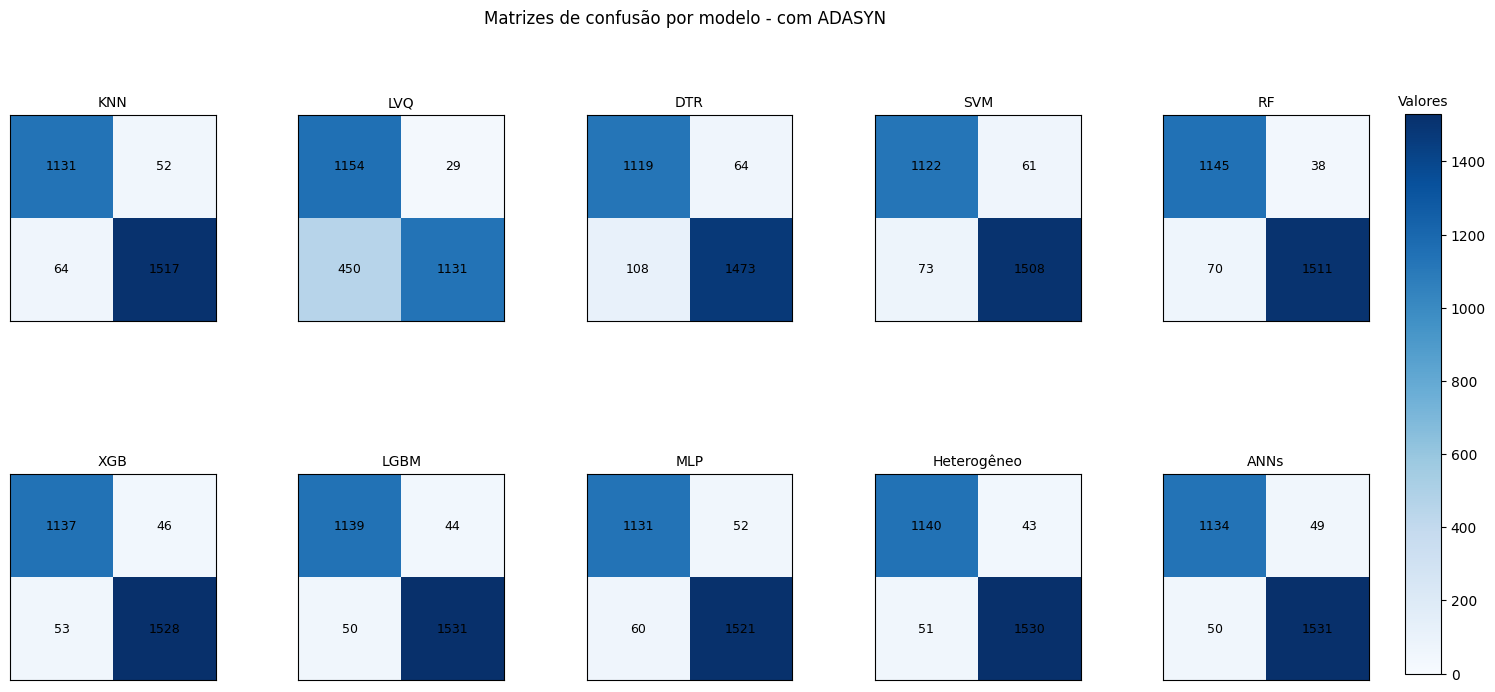

In [ ]:
confusion_matrices = test_metrics_with_adasyn['CM']
models = test_metrics_with_adasyn['model_name']

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
fig.subplots_adjust(right=0.88, wspace=0.4, hspace=0.4)

vmin, vmax = 0, max(np.max(cm) for cm in confusion_matrices)
for ax, cm, model in zip(axes.ravel(), confusion_matrices, models):
    im = ax.imshow(cm, cmap="Blues", vmin=vmin, vmax=vmax)
    ax.set_title(model, fontsize=10)
    for i in range(len(cm)):
        for j in range(len(cm[i])):
            ax.text(j, i, cm[i][j], ha="center", va="center", color="black", fontsize=9)
    ax.set_xticks([])
    ax.set_yticks([])

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7]) 
fig.colorbar(im, cax=cbar_ax, orientation="vertical")
cbar_ax.set_title("Valores", fontsize=10)
fig.suptitle('Matrizes de confusão por modelo - com ADASYN')

plt.show()

## Wilcoxon

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

list_of_metrics_names = ['ACSA', 'f1_score', 'test_accuracy', 'train_accuracy', 'precision', 'recall', 'inference_time', 'training_time']
list_of_statistics = []
list_of_pvalues = []
list_of_diff_flags = []
list_of_means_with_adasyn = []
list_of_means_no_adasyn = []

for metric in list_of_metrics_names:
    statistic, p_value = wilcoxon(val_metrics_no_adasyn[metric],val_metrics_with_adasyn[metric])
    if p_value < 0.05:
        are_different = True
    else:
        are_different = False
    
    list_of_statistics.append(statistic)
    list_of_pvalues.append(p_value)
    list_of_diff_flags.append(are_different)
    list_of_means_no_adasyn.append(test_metrics_no_adasyn[metric].mean())
    list_of_means_with_adasyn.append(test_metrics_with_adasyn[metric].mean())

wilcoxon_dict = {
    'metric': list_of_metrics_names,
    'statistic': list_of_statistics,
    'mean_with_adasyn': list_of_means_with_adasyn,
    'mean_no_adasyn': list_of_means_no_adasyn,
    'p-value': list_of_pvalues,
    'are_different': list_of_diff_flags
}

wilcoxon_results_val = pd.DataFrame(wilcoxon_dict)

metrics_with_difference = wilcoxon_results_val[wilcoxon_results_val['are_different'] == True]['metric'].tolist()

In [ ]:
wilcoxon_results_val

In [ ]:
from scipy.stats import ttest_rel, wilcoxon

list_of_metrics_names = ['ACSA', 'f1_score', 'test_accuracy', 'train_accuracy', 'precision', 'recall', 'inference_time', 'training_time']
list_of_statistics = []
list_of_pvalues = []
list_of_diff_flags = []
list_of_means_with_adasyn = []
list_of_means_no_adasyn = []

for metric in list_of_metrics_names:
    statistic, p_value = wilcoxon(test_metrics_no_adasyn[metric],test_metrics_with_adasyn[metric])
    if p_value < 0.05:
        are_different = True
    else:
        are_different = False
    
    list_of_statistics.append(statistic)
    list_of_pvalues.append(p_value)
    list_of_diff_flags.append(are_different)
    list_of_means_no_adasyn.append(test_metrics_no_adasyn[metric].mean())
    list_of_means_with_adasyn.append(test_metrics_with_adasyn[metric].mean())

wilcoxon_dict = {
    'metric': list_of_metrics_names,
    'statistic': list_of_statistics,
    'mean_with_adasyn': list_of_means_with_adasyn,
    'mean_no_adasyn': list_of_means_no_adasyn,
    'p-value': list_of_pvalues,
    'are_different': list_of_diff_flags
}

wilcoxon_results_test = pd.DataFrame(wilcoxon_dict)

metrics_with_difference = wilcoxon_results_test[wilcoxon_results_test['are_different'] == True]['metric'].tolist()

In [ ]:
wilcoxon_results_test

,metric,statistic,mean_with_adasyn,mean_no_adasyn,p-value,are_different
0,ACSA,25.0,0.947254,0.948532,0.845703,False
1,f1_score,6.0,0.949842,0.958761,0.027344,True
2,test_accuracy,6.0,0.945478,0.951881,0.050612,False
3,train_accuracy,0.0,0.964521,0.970245,0.001953,True
4,precision,0.0,0.968824,0.946308,0.001953,True
5,recall,0.0,0.934915,0.971790,0.001953,True
6,inference_time,3.0,1.541282,0.267402,0.009766,True
7,training_time,10.0,23.375941,23.820417,0.083984,False
